## **ONLINE**

In [16]:
# Pulizia
from IPython import get_ipython
get_ipython().magic('clear')
get_ipython().magic('reset -f')

# Import libraries:
import numpy as np
import scipy.sparse as sparse
import scipy.sparse.linalg as linalg
import time
import sys
import json 
import h5py
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sp 

# Import user defined libraries:
from solver_class import FiniteElementCylinderSolver, ReducedBasisCylinderSolver

/var/folders/gs/p2p59ns16hlgpqv_027665gm0000gn/T/ipykernel_2093/579417616.py:3: DeprecationWarning: `magic(...)` is deprecated since IPython 0.13 (warning added in 8.1), use run_line_magic(magic_name, parameter_s).
  get_ipython().magic('clear')
/var/folders/gs/p2p59ns16hlgpqv_027665gm0000gn/T/ipykernel_2093/579417616.py:4: DeprecationWarning: `magic(...)` is deprecated since IPython 0.13 (warning added in 8.1), use run_line_magic(magic_name, parameter_s).
  get_ipython().magic('reset -f')


In [17]:
# Apri il file in modalità lettura
with h5py.File('checkpoint/matrici_RB.h5', 'r') as hf:
    # Accedi ai dataset e ricrea le matrici
    MM_RB = hf['MM_RB'][:,:]
    FF_RB = hf['FF_RB'][:]
    KK_RB = hf['KK_RB'][:,:,:]
    AA_RB = hf['AA_RB'][:]
    ZZ_CO = hf['ZZ_CO'][:]   
    II_CO = hf['II_CO'][:]
    basis = hf['basis'][:,:]   

print(MM_RB.shape)
print(ZZ_CO.shape)

(173, 173)
(8,)


In [18]:
# Lettura dei parametri dal file JSON
with open("reference case/Reference_parameters.json", "r") as json_file:
    parameters = json.load(json_file)
FISSION_ENERGY = parameters["FISSION_ENERGY"]                       
FISSION_RATE = parameters["FISSION_RATE"]                   
RADIUS = parameters["RADIUS"]
LENGTH = parameters["LENGTH"]
FISSION_YIELD = parameters["FISSION_YIELD"]                 
FUEL_THERMAL_CONDUCTIVITY = parameters["FUEL_THERMAL_CONDUCTIVITY"]
T_BC = parameters["T_BC"]  
TIME_FINAL = 1.00E+07
TIME_DELTA = 1.00E+04

In [19]:
# IMPLEMENTARE IN SCIANTIX
SOURCE_C = FISSION_RATE * FISSION_YIELD                      #[atm / (m^3 s)]
GAMMA_T = (FISSION_RATE * FISSION_ENERGY * LENGTH**2)/(FUEL_THERMAL_CONDUCTIVITY)

TT = T_BC + GAMMA_T * (1 - ZZ_CO**2) / 2

WW = 7.60E-10 * np.exp(- 4.86E-19 / (TT * 1.380649E-23)) +\
     5.64E-25 * np.exp(- 1.91E-19 / (TT * 1.380649E-23)) * np.sqrt(FISSION_RATE) +\
     8.00E-40 * FISSION_RATE

CC_CO = np.hstack((II_CO @ WW / RADIUS**2, II_CO @ WW / LENGTH**2))

SS_RB = np.tensordot(CC_CO, KK_RB, axes=[0, 0])
QQ_RB = SOURCE_C * FF_RB

LHS_RB_static = MM_RB + TIME_DELTA * SS_RB
RHS_RB_static = TIME_DELTA * QQ_RB
LU, PIV = sp.linalg.lu_factor(LHS_RB_static)

import time
old_sol_RB = np.zeros((MM_RB.shape[0], 1))
solution_RB = np.zeros((1001))
start_time = time.time()
for ii in range(1, 1001):
    old_sol_RB = sp.linalg.lu_solve((LU, PIV), RHS_RB_static + MM_RB.dot(old_sol_RB))
    #value = np.dot(AA_RB, old_sol_RB)[0]
    solution_RB[ii] = np.dot(AA_RB, old_sol_RB)[0]
    print(solution_RB[ii])
end_time = time.time()
elsapsed_time = end_time-start_time
print(elsapsed_time)

6.07824492920305e+22
1.1626510187397868e+23
1.6790523464444074e+23
2.164345952503937e+23
2.6231233594514924e+23
3.0586114501492084e+23
3.473240584359337e+23
3.868929044184863e+23
4.247243214017505e+23
4.609495547280394e+23
4.956808266667328e+23
5.2901567819067116e+23
5.6104004065423386e+23
5.918304753313685e+23
6.214558472262678e+23
6.499786023361633e+23
6.774557597688762e+23
7.039396943728672e+23
7.29478762636129e+23
7.541178094819613e+23
7.778985833243856e+23
8.008600796145497e+23
8.230388280521706e+23
8.444691349846212e+23
8.651832898385118e+23
8.852117424380868e+23
9.045832565676653e+23
9.233250439977854e+23
9.414628823224544e+23
9.590212192809629e+23
9.760232657130493e+23
9.924910788853308e+23
1.0084456376030311e+24
1.0239069102646051e+24
1.0388939168123549e+24
1.0534247853687014e+24
1.0675168042160664e+24
1.0811864696720382e+24
1.0944495303250234e+24
1.1073210280251442e+24
1.1198153359672746e+24
1.1319461941554673e+24
1.1437267424986159e+24
1.1551695517542658e+24
1.16628665251012

Errore in python: 4.823E-09%


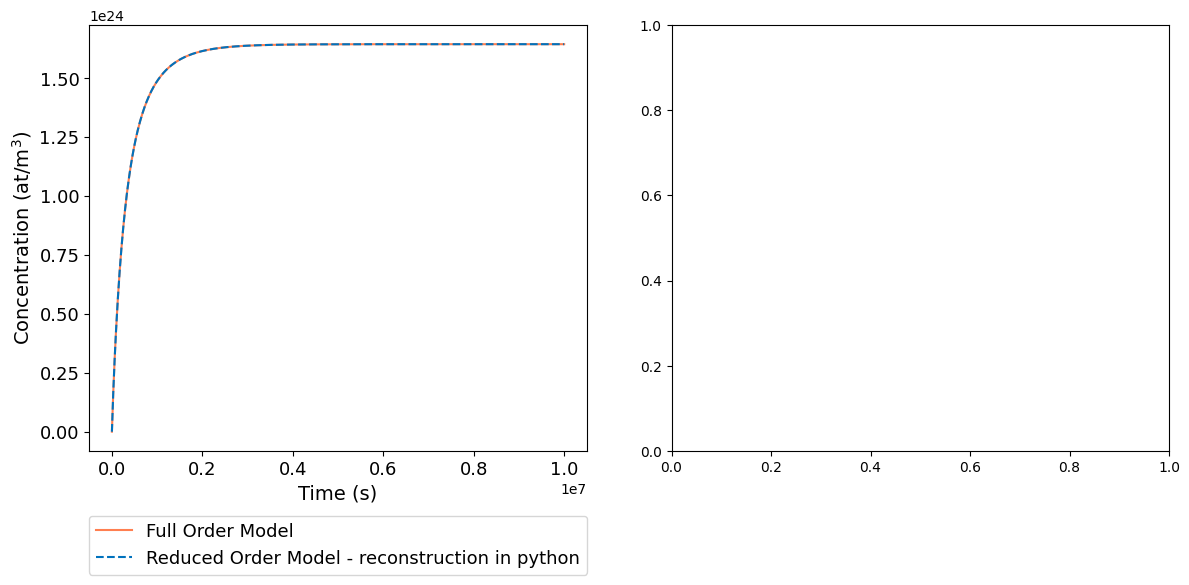

In [22]:
solution_FO = np.loadtxt('reference case/Fullorder_Caverage.csv', delimiter=',')
#sciantix =  pd.read_table("/Users/martina/Library/CloudStorage/OneDrive-PolitecnicodiMilano/PhD/Git/rom-cylinder_DEIM-POD/trial/reference case/output.txt")

error = (np.abs(solution_FO[-1] - solution_RB[-1])/solution_FO[-1])*100
print(f"Errore in python: {error:.3E}%")
#error = (np.abs(full_order['Average dC (atm/m^3)'].iloc[-1] - sciantix['Xe in grain (at/m3)'].iloc[-1])/full_order['Average dC (atm/m^3)'].iloc[-1])*100
#print(f"Errore in sciantix: {error:.3E}%")

# error_python = (np.abs(full_order.iloc[:, 1] - reconstructed_solution) / full_order.iloc[:, 1])*100
# error_python_max = np.max(error_python)
# print(f"Errore massimo in python: {error_python_max:.3E}%")

# error_sciantix = (np.abs(full_order.iloc[:, 1] - sciantix['Xe in grain (at/m3)']) / full_order.iloc[:, 1]) * 100
# error_sciantix_max = np.max(error_sciantix)
# print(f"Errore massimo in sciantix: {error_sciantix_max:.3E}%")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))
ax1.plot(np.linspace(0, 1e7, len(solution_FO)), solution_FO, label = 'Full Order Model', color='#FF7F50', linewidth=1.5)
ax1.plot(np.linspace(0, 1e7, 1001),solution_RB , '--',label = 'Reduced Order Model - reconstruction in python', color='#0072bd', linewidth=1.5)
#ax1.plot(np.linspace(0, 1e7, 1001),sciantix['Xe in grain (at/m3)'], '--', label='Reduced Order Model - reconstruction in sciantix', color='#050402', linewidth=1.5)
ax1.tick_params(axis="y", labelsize=13)
ax1.tick_params(axis='x', labelsize=13)
ax1.ticklabel_format(useOffset=False)
ax1.set_xlabel('Time (s)',fontsize=14)
ax1.set_ylabel('Concentration (at/m$^3$)',fontsize=14)
ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.13), fancybox=True, shadow=False, ncol=1, fontsize=13)

# ax2.plot(np.linspace(0, 1e7, 1001), error_python, color='#FF7F50', linewidth=1.5)
# ax2.tick_params(axis="y", labelsize=13)
# ax2.tick_params(axis='x', labelsize=13)
# ax2.ticklabel_format(useOffset=False)
# ax2.set_xlabel('Time (s)',fontsize=14)
# ax2.set_ylabel('Error in python %',fontsize=14)


plt.tight_layout()